# 의료비용 예측 딥러닝 모델

## 개요
보험 데이터를 활용한 의료비용 예측 딥러닝 회귀 모델입니다.

## 목표
- 개인의 특성(나이, BMI, 흡연여부 등)을 기반으로 의료비용을 예측
- 딥러닝 회귀 모델을 통한 연속형 값 예측
- 모델 성능 평가 및 시각화

## 데이터셋 정보
- **파일명**: insurance.csv
- **주요 특성**: age, sex, bmi, children, smoker, region, charges
- **목표 변수**: charges (의료비용)

In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
from typing import Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [21]:
# 파일 경로 및 모델 설정
DATA_PATH = "../../data/insurance.csv"
MODEL_SAVE_PATH = "medical_cost_model.keras"
HISTORY_SAVE_PATH = "training_history.pkl"

# 하이퍼파라미터 설정
RANDOM_SEED = 42
TEST_SIZE = 0.2
VALIDATION_SPLIT = 0.2
MAX_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10

# 모델 아키텍처 설정
HIDDEN_LAYER_1_UNITS = 128
HIDDEN_LAYER_2_UNITS = 64
LEARNING_RATE = 0.001

# 시드 고정
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [22]:
def load_insurance_data() -> Optional[pd.DataFrame]:
    """
    보험 데이터를 로딩하고 기본적인 정보를 출력합니다.
    
    Returns:
        pd.DataFrame: 로딩된 데이터프레임 또는 None (실패시)
    """
    print("=" * 50)
    print("📊 데이터 로딩 중...")
    print("=" * 50)
    
    try:
        df = pd.read_csv(DATA_PATH)
        print(f"✅ 데이터 로딩 성공: {df.shape[0]}개 행, {df.shape[1]}개 열")
        
        # 기본 정보 출력
        print("\n📋 데이터 기본 정보:")
        print(df.info())
        
        print("\n📈 수치형 데이터 요약 통계:")
        print(df.describe())
        
        print("\n🔍 범주형 데이터 분포:")
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            print(f"\n{col} 분포:")
            print(df[col].value_counts())
            
        # 결측치 확인
        print(f"\n❌ 결측치 확인:")
        missing_values = df.isnull().sum()
        if missing_values.sum() == 0:
            print("결측치가 없습니다.")
        else:
            print(missing_values[missing_values > 0])
            
        return df
    
    except FileNotFoundError:
        print(f"❌ 오류: {DATA_PATH} 파일을 찾을 수 없습니다.")
        return None
    except Exception as e:
        print(f"❌ 데이터 로딩 중 오류 발생: {str(e)}")
        return None

In [23]:
def visualize_target_distribution(df: pd.DataFrame) -> None:
    """
    목표 변수(의료비용)의 분포를 시각화합니다.
    
    Args:
        df (pd.DataFrame): 입력 데이터프레임
    """
    print("📊 의료비용 분포 시각화")
    
    plt.figure(figsize=(12, 5))
    
    # 히스토그램과 KDE
    plt.subplot(1, 2, 1)
    sns.histplot(df["charges"], bins=50, kde=True, alpha=0.7)
    plt.title('의료비용 분포 (히스토그램)', fontsize=14, fontweight='bold')
    plt.xlabel('의료비용 (달러)', fontsize=12)
    plt.ylabel('빈도', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 박스플롯
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df["charges"])
    plt.title('의료비용 분포 (박스플롯)', fontsize=14, fontweight='bold')
    plt.ylabel('의료비용 (달러)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 기본 통계량 출력
    print(f"\n📊 의료비용 기본 통계:")
    print(f"평균: ${df['charges'].mean():,.2f}")
    print(f"중앙값: ${df['charges'].median():,.2f}")
    print(f"표준편차: ${df['charges'].std():,.2f}")
    print(f"최솟값: ${df['charges'].min():,.2f}")
    print(f"최댓값: ${df['charges'].max():,.2f}")

In [24]:
def preprocess_insurance_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    보험 데이터를 전처리합니다.
    - 범주형 변수 원핫인코딩
    - 수치형 변수 표준화
    
    Args:
        df (pd.DataFrame): 원본 데이터프레임
        
    Returns:
        pd.DataFrame: 전처리된 데이터프레임
    """
    print("=" * 50)
    print("🔄 데이터 전처리 진행 중...")
    print("=" * 50)
    
    df_processed = df.copy()
    
    # 1. 범주형 변수 원핫인코딩
    print("1️⃣ 범주형 변수 원핫인코딩 수행")
    categorical_features = ['sex', 'smoker', 'region']
    
    print(f"원핫인코딩 대상 변수: {categorical_features}")
    df_encoded = pd.get_dummies(
        df_processed, 
        columns=categorical_features, 
        drop_first=True,  # 다중공선성 방지를 위해 첫 번째 더미변수 제거
        dtype=np.float32  # 데이터 타입을 float32로 명시
    )
    
    print(f"✅ 원핫인코딩 완료. 변수 개수: {len(df.columns)} → {len(df_encoded.columns)}")
    print(f"새로운 컬럼명: {list(df_encoded.columns)}")
    
    # 2. 수치형 변수 표준화 (Z-score 정규화)
    print("\n2️⃣ 수치형 변수 표준화 수행")
    numerical_features = ['age', 'bmi', 'children']
    
    for feature in numerical_features:
        mean_val = df_encoded[feature].mean()
        std_val = df_encoded[feature].std()
        df_encoded[feature] = ((df_encoded[feature] - mean_val) / std_val).astype(np.float32)
        print(f"   {feature}: 평균={mean_val:.2f}, 표준편차={std_val:.2f} → 표준화 완료")
    
    # charges 컬럼도 float32로 변환
    df_encoded['charges'] = df_encoded['charges'].astype(np.float32)
    
    print("\n✅ 데이터 전처리 완료!")
    print(f"최종 데이터 크기: {df_encoded.shape}")
    print(f"최종 데이터 타입: {df_encoded.dtypes.unique()}")
    
    # 전처리 후 데이터 미리보기
    print(f"\n📋 전처리된 데이터 미리보기:")
    print(df_encoded.head())
    
    return df_encoded

In [25]:
def split_train_test_data(df: pd.DataFrame) -> Dict[str, np.ndarray]:
    """
    데이터를 훈련용과 테스트용으로 분할합니다.
    
    Args:
        df (pd.DataFrame): 전처리된 데이터프레임
        
    Returns:
        Dict[str, np.ndarray]: 훈련/테스트 데이터셋이 담긴 딕셔너리
    """
    print("=" * 50)
    print("✂️ 데이터 분할 진행 중...")
    print("=" * 50)
    
    # 특성(X)과 타겟(y) 분리
    feature_columns = df.drop('charges', axis=1).columns.tolist()
    X = df[feature_columns].values.astype(np.float32)  # float32로 명시적 변환
    y = df['charges'].values.astype(np.float32)        # float32로 명시적 변환
    
    print(f"📊 특성 변수 개수: {X.shape[1]}개")
    print(f"📊 특성 변수명: {feature_columns}")
    print(f"📊 전체 데이터 크기: {X.shape[0]}개")
    print(f"📊 데이터 타입: X={X.dtype}, y={y.dtype}")
    
    # 훈련/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=TEST_SIZE, 
        random_state=RANDOM_SEED,
        shuffle=True
    )
    
    print(f"\n✅ 데이터 분할 완료!")
    print(f"   📈 훈련 데이터: {X_train.shape[0]}개 ({(1-TEST_SIZE)*100:.0f}%)")
    print(f"   📊 테스트 데이터: {X_test.shape[0]}개 ({TEST_SIZE*100:.0f}%)")
    print(f"   🎯 특성 차원: {X_train.shape[1]}개")
    
    # 데이터 통계 확인
    print(f"\n📈 훈련 데이터 타겟 통계:")
    print(f"   평균: ${y_train.mean():,.2f}")
    print(f"   표준편차: ${y_train.std():,.2f}")
    
    print(f"\n📊 테스트 데이터 타겟 통계:")
    print(f"   평균: ${y_test.mean():,.2f}")
    print(f"   표준편차: ${y_test.std():,.2f}")
    
    return {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "feature_names": feature_columns
    }

In [26]:
def create_medical_cost_model(input_shape: int) -> keras.Model:
    """
    의료비용 예측을 위한 딥러닝 모델을 생성합니다.
    
    Args:
        input_shape (int): 입력 특성의 개수
        
    Returns:
        keras.Model: 컴파일된 딥러닝 모델
    """
    print("=" * 50)
    print("🏗️ 딥러닝 모델 구축 중...")
    print("=" * 50)
    
    # Sequential 모델 생성
    model = keras.Sequential([
        # 입력층 → 첫 번째 은닉층 (128 노드, ReLU 활성화)
        layers.Dense(
            HIDDEN_LAYER_1_UNITS, 
            activation='relu', 
            input_shape=(input_shape,),
            name='hidden_layer_1'
        ),
        
        # 두 번째 은닉층 (64 노드, ReLU 활성화)
        layers.Dense(
            HIDDEN_LAYER_2_UNITS, 
            activation='relu',
            name='hidden_layer_2'
        ),
        
        # 출력층 (1 노드, 회귀이므로 활성화 함수 없음)
        layers.Dense(1, name='output_layer')
    ], name='medical_cost_prediction_model')
    
    # 모델 컴파일
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),
        loss='mse',  # 평균제곱오차 (회귀 문제)
        metrics=['mae']  # 평균절대오차
    )
    
    print("✅ 모델 구축 및 컴파일 완료!")
    print(f"\n📊 모델 구조:")
    model.summary()
    
    print(f"\n⚙️ 모델 설정:")
    print(f"   - 최적화 알고리즘: RMSprop (학습률: {LEARNING_RATE})")
    print(f"   - 손실 함수: 평균제곱오차 (MSE)")
    print(f"   - 평가 지표: 평균절대오차 (MAE)")
    print(f"   - 첫 번째 은닉층: {HIDDEN_LAYER_1_UNITS} 노드")
    print(f"   - 두 번째 은닉층: {HIDDEN_LAYER_2_UNITS} 노드")
    
    return model

In [27]:
def train_model(model: keras.Model, data: Dict[str, np.ndarray]) -> keras.callbacks.History:
    """
    모델을 훈련하고 결과를 저장합니다.
    
    Args:
        model (keras.Model): 훈련할 모델
        data (Dict[str, np.ndarray]): 훈련/테스트 데이터
        
    Returns:
        keras.callbacks.History: 훈련 히스토리
    """
    print("=" * 50)
    print("🎯 모델 훈련 시작...")
    print("=" * 50)
    
    # 조기 종료 콜백 설정
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',  # 검증 손실을 모니터링
        patience=EARLY_STOPPING_PATIENCE,  # 10번의 에포크 동안 개선이 없으면 중단
        restore_best_weights=True,  # 최상의 가중치로 복원
        verbose=1
    )
    
    print(f"⚙️ 훈련 설정:")
    print(f"   - 최대 에포크: {MAX_EPOCHS}")
    print(f"   - 검증 데이터 비율: {VALIDATION_SPLIT*100:.0f}%")
    print(f"   - 조기 종료 patience: {EARLY_STOPPING_PATIENCE}")
    print(f"   - 훈련 데이터 크기: {data['X_train'].shape[0]}")
    
    print(f"\n🚀 훈련 시작!")
    
    # 모델 훈련
    history = model.fit(
        data["X_train"], 
        data["y_train"],
        epochs=MAX_EPOCHS,
        validation_split=VALIDATION_SPLIT,
        callbacks=[early_stopping],
        verbose=1  # 에포크별 진행상황 출력
    )
    
    print(f"\n✅ 훈련 완료!")
    print(f"   - 총 훈련 에포크: {len(history.history['loss'])}")
    print(f"   - 최종 훈련 손실: {history.history['loss'][-1]:.4f}")
    print(f"   - 최종 검증 손실: {history.history['val_loss'][-1]:.4f}")
    print(f"   - 최종 훈련 MAE: {history.history['mae'][-1]:.4f}")
    print(f"   - 최종 검증 MAE: {history.history['val_mae'][-1]:.4f}")
    
    # 모델 저장
    try:
        model.save(MODEL_SAVE_PATH)
        print(f"💾 모델 저장 완료: {MODEL_SAVE_PATH}")
    except Exception as e:
        print(f"❌ 모델 저장 실패: {str(e)}")
    
    # 훈련 히스토리 저장
    try:
        with open(HISTORY_SAVE_PATH, "wb") as f:
            pickle.dump(history.history, f)
        print(f"💾 훈련 히스토리 저장 완료: {HISTORY_SAVE_PATH}")
    except Exception as e:
        print(f"❌ 훈련 히스토리 저장 실패: {str(e)}")
    
    return history

In [28]:
def evaluate_and_visualize_model(data: Dict[str, np.ndarray]) -> None:
    """
    저장된 모델을 로드하여 평가하고 결과를 시각화합니다.
    
    Args:
        data (Dict[str, np.ndarray]): 평가용 데이터
    """
    print("=" * 50)
    print("📊 모델 평가 및 시각화...")
    print("=" * 50)
    
    try:
        # 저장된 모델 로드
        model = keras.models.load_model(MODEL_SAVE_PATH)
        print(f"✅ 모델 로드 완료: {MODEL_SAVE_PATH}")
        
        # 저장된 훈련 히스토리 로드
        with open(HISTORY_SAVE_PATH, "rb") as f:
            history = pickle.load(f)
        print(f"✅ 훈련 히스토리 로드 완료: {HISTORY_SAVE_PATH}")
        
    except FileNotFoundError as e:
        print(f"❌ 파일을 찾을 수 없습니다: {str(e)}")
        print("먼저 모델을 훈련해주세요.")
        return
    except Exception as e:
        print(f"❌ 모델/히스토리 로드 중 오류 발생: {str(e)}")
        return
    
    # 1. 훈련 히스토리 시각화
    visualize_training_history(history)
    
    # 2. 테스트 데이터 평가
    evaluate_test_performance(model, data)
    
    # 3. 예측 vs 실제값 시각화
    visualize_predictions(model, data)


def visualize_training_history(history: Dict) -> None:
    """
    훈련 히스토리를 시각화합니다.
    
    Args:
        history (Dict): 훈련 히스토리 딕셔너리
    """
    print("\n📈 1. 훈련 히스토리 시각화")
    
    hist_df = pd.DataFrame(history)
    epochs = range(1, len(hist_df) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # 손실 함수 그래프
    plt.subplot(1, 3, 1)
    plt.plot(epochs, hist_df['loss'], 'b-', label='훈련 손실', linewidth=2)
    plt.plot(epochs, hist_df['val_loss'], 'r-', label='검증 손실', linewidth=2)
    plt.title('모델 손실 (MSE)', fontsize=14, fontweight='bold')
    plt.xlabel('에포크', fontsize=12)
    plt.ylabel('평균제곱오차', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # MAE 그래프
    plt.subplot(1, 3, 2)
    plt.plot(epochs, hist_df['mae'], 'b-', label='훈련 MAE', linewidth=2)
    plt.plot(epochs, hist_df['val_mae'], 'r-', label='검증 MAE', linewidth=2)
    plt.title('평균절대오차 (MAE)', fontsize=14, fontweight='bold')
    plt.xlabel('에포크', fontsize=12)
    plt.ylabel('평균절대오차', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 손실 비교 (마지막 20 에포크)
    plt.subplot(1, 3, 3)
    last_epochs = max(1, len(epochs) - 20)
    plt.plot(epochs[last_epochs:], hist_df['loss'][last_epochs:], 'b-', label='훈련 손실', linewidth=2)
    plt.plot(epochs[last_epochs:], hist_df['val_loss'][last_epochs:], 'r-', label='검증 손실', linewidth=2)
    plt.title('최근 20 에포크 손실', fontsize=14, fontweight='bold')
    plt.xlabel('에포크', fontsize=12)
    plt.ylabel('평균제곱오차', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def evaluate_test_performance(model: keras.Model, data: Dict[str, np.ndarray]) -> None:
    """
    테스트 데이터에 대한 모델 성능을 평가합니다.
    
    Args:
        model (keras.Model): 평가할 모델
        data (Dict[str, np.ndarray]): 테스트 데이터
    """
    print("\n📊 2. 테스트 데이터 성능 평가")
    
    # 테스트 데이터 평가
    test_loss, test_mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
    
    print(f"📈 테스트 결과:")
    print(f"   - 평균제곱오차 (MSE): {test_loss:.2f}")
    print(f"   - 평균절대오차 (MAE): ${test_mae:.2f}")
    print(f"   - 제곱근 평균제곱오차 (RMSE): ${np.sqrt(test_loss):.2f}")
    
    # 실제값의 평균과 비교
    mean_actual = np.mean(data["y_test"])
    print(f"\n📊 성능 해석:")
    print(f"   - 테스트 데이터 실제 의료비용 평균: ${mean_actual:.2f}")
    print(f"   - MAE / 평균 비율: {(test_mae/mean_actual)*100:.1f}%")
    
    if (test_mae/mean_actual) < 0.15:
        print("   ✅ 우수한 성능 (오차율 15% 미만)")
    elif (test_mae/mean_actual) < 0.25:
        print("   ⚠️ 보통 성능 (오차율 15-25%)")
    else:
        print("   ❌ 성능 개선 필요 (오차율 25% 초과)")


def visualize_predictions(model: keras.Model, data: Dict[str, np.ndarray]) -> None:
    """
    예측값과 실제값을 시각화합니다.
    
    Args:
        model (keras.Model): 예측에 사용할 모델
        data (Dict[str, np.ndarray]): 테스트 데이터
    """
    print("\n🎯 3. 예측 결과 시각화")
    
    # 예측 수행
    predictions = model.predict(data["X_test"]).flatten()
    actual = data["y_test"]
    
    # 시각화
    plt.figure(figsize=(15, 5))
    
    # 산점도 (예측 vs 실제)
    plt.subplot(1, 3, 1)
    plt.scatter(actual, predictions, alpha=0.6, s=30)
    
    # 완벽한 예측선 (y=x)
    min_val = min(actual.min(), predictions.min())
    max_val = max(actual.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='완벽한 예측선')
    
    plt.xlabel('실제 의료비용 ($)', fontsize=12)
    plt.ylabel('예측 의료비용 ($)', fontsize=12)
    plt.title('예측값 vs 실제값', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 잔차 플롯
    plt.subplot(1, 3, 2)
    residuals = actual - predictions
    plt.scatter(predictions, residuals, alpha=0.6, s=30)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('예측 의료비용 ($)', fontsize=12)
    plt.ylabel('잔차 (실제값 - 예측값)', fontsize=12)
    plt.title('잔차 플롯', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 예측 오차 히스토그램
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('잔차 (실제값 - 예측값)', fontsize=12)
    plt.ylabel('빈도', fontsize=12)
    plt.title('예측 오차 분포', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 통계 요약
    print(f"\n📊 예측 성능 요약:")
    print(f"   - 총 테스트 샘플 수: {len(actual)}")
    print(f"   - 평균 절대 오차: ${np.mean(np.abs(residuals)):.2f}")
    print(f"   - 잔차 표준편차: ${np.std(residuals):.2f}")
    print(f"   - 결정계수 (R²): {1 - np.sum(residuals**2) / np.sum((actual - np.mean(actual))**2):.3f}")

🚀 의료비용 예측 딥러닝 파이프라인 시작
📊 데이터 로딩 중...
✅ 데이터 로딩 성공: 1338개 행, 7개 열

📋 데이터 기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

📈 수치형 데이터 요약 통계:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.

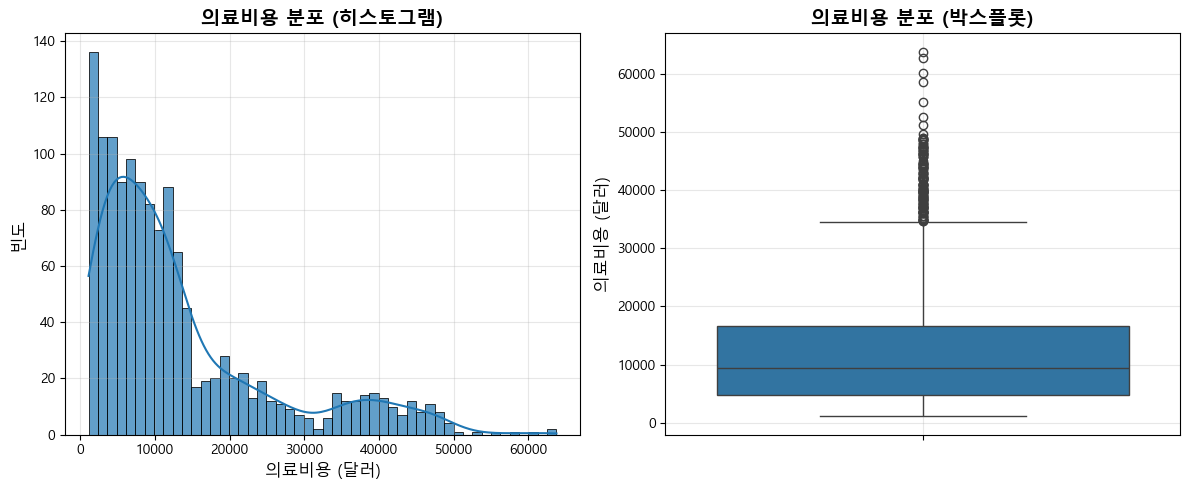


📊 의료비용 기본 통계:
평균: $13,270.42
중앙값: $9,382.03
표준편차: $12,110.01
최솟값: $1,121.87
최댓값: $63,770.43
🔄 데이터 전처리 진행 중...
1️⃣ 범주형 변수 원핫인코딩 수행
원핫인코딩 대상 변수: ['sex', 'smoker', 'region']
✅ 원핫인코딩 완료. 변수 개수: 7 → 9
새로운 컬럼명: ['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']

2️⃣ 수치형 변수 표준화 수행
   age: 평균=39.21, 표준편차=14.05 → 표준화 완료
   bmi: 평균=30.66, 표준편차=6.10 → 표준화 완료
   children: 평균=1.09, 표준편차=1.21 → 표준화 완료

✅ 데이터 전처리 완료!
최종 데이터 크기: (1338, 9)
최종 데이터 타입: [dtype('float32')]

📋 전처리된 데이터 미리보기:
        age       bmi  children       charges  sex_male  smoker_yes  \
0 -1.438226 -0.453151 -0.908274  16884.923828       0.0         1.0   
1 -1.509401  0.509431 -0.078738   1725.552246       1.0         0.0   
2 -0.797655  0.383164  1.580335   4449.461914       1.0         0.0   
3 -0.441782 -1.305043 -0.908274  21984.470703       1.0         0.0   
4 -0.512957 -0.292447 -0.908274   3866.855225       1.0         0.0   

   region_northwest  reg

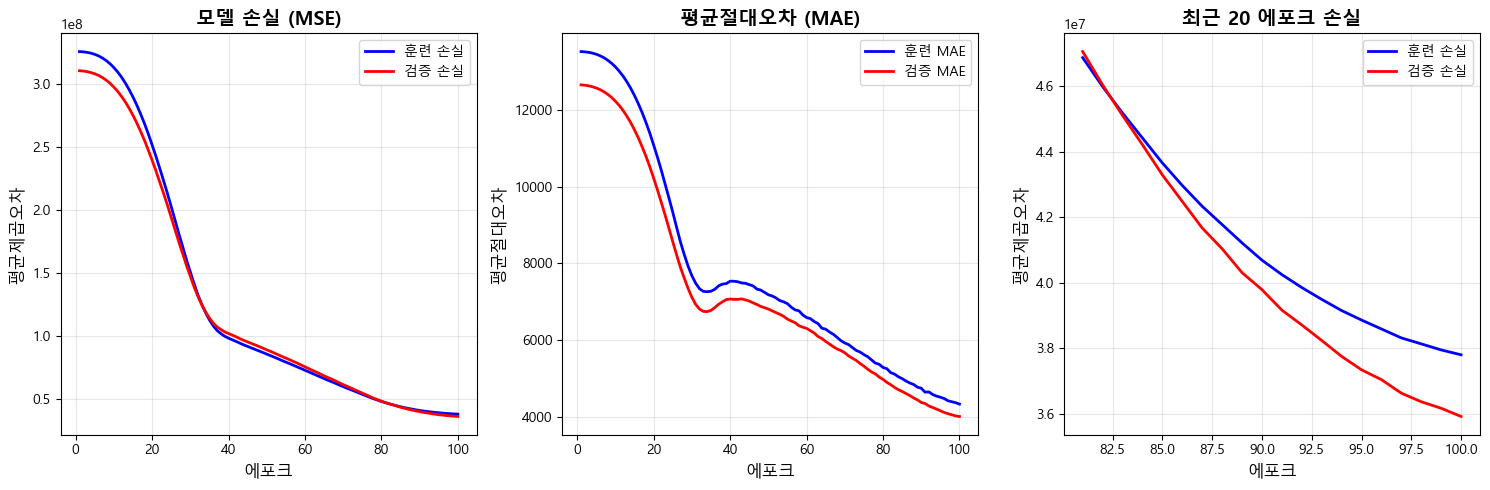


📊 2. 테스트 데이터 성능 평가
📈 테스트 결과:
   - 평균제곱오차 (MSE): 34908088.00
   - 평균절대오차 (MAE): $4275.93
   - 제곱근 평균제곱오차 (RMSE): $5908.31

📊 성능 해석:
   - 테스트 데이터 실제 의료비용 평균: $12968.32
   - MAE / 평균 비율: 33.0%
   ❌ 성능 개선 필요 (오차율 25% 초과)

🎯 3. 예측 결과 시각화
9/9 [==============================] - 0s 1ms/step


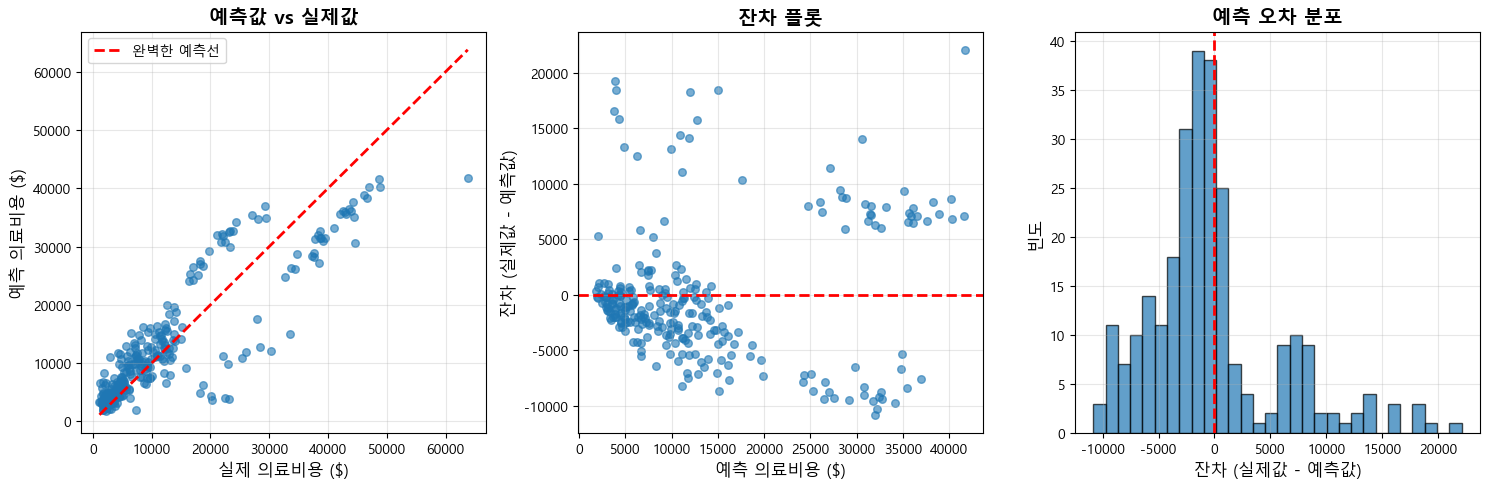


📊 예측 성능 요약:
   - 총 테스트 샘플 수: 268
   - 평균 절대 오차: $4275.93
   - 잔차 표준편차: $5901.52
   - 결정계수 (R²): 0.775

✅ 파이프라인 실행 완료!


In [29]:
def main_pipeline(train_new_model: bool = False) -> None:
    """
    전체 딥러닝 파이프라인을 실행합니다.
    
    Args:
        train_new_model (bool): 새로운 모델을 훈련할지 여부
    """
    print("🚀 의료비용 예측 딥러닝 파이프라인 시작")
    print("=" * 60)
    
    # 1. 데이터 로딩
    df = load_insurance_data()
    if df is None:
        return
    
    # 2. 탐색적 데이터 분석
    visualize_target_distribution(df)
    
    # 3. 데이터 전처리
    df_processed = preprocess_insurance_data(df)
    
    # 4. 데이터 분할
    data = split_train_test_data(df_processed)
    
    if train_new_model:
        # 5. 모델 생성
        model = create_medical_cost_model(input_shape=data['X_train'].shape[1])
        
        # 6. 모델 훈련
        history = train_model(model, data)
    
    # 7. 모델 평가 및 시각화
    evaluate_and_visualize_model(data)
    
    print("\n" + "=" * 60)
    print("✅ 파이프라인 실행 완료!")

# 실행 옵션 설정
TRAIN_NEW_MODEL = True  # 새로운 모델을 훈련하려면 True, 기존 모델을 사용하려면 False

# 파이프라인 실행
if __name__ == "__main__":
    main_pipeline(train_new_model=TRAIN_NEW_MODEL)

## 10. 추가 분석 및 개별 함수 테스트

아래 셀들은 개별 기능을 테스트하거나 추가 분석을 위해 사용할 수 있습니다.

In [ ]:
# 개별 함수 테스트용 코드 (필요시 주석 해제하여 실행)

# 1. 데이터만 로딩하여 확인
# df = load_insurance_data()

# 2. 특정 시각화만 실행
# if 'df' in locals():
#     visualize_target_distribution(df)

# 3. 전처리 결과만 확인
# if 'df' in locals():
#     df_processed = preprocess_insurance_data(df)

# 4. 기존에 훈련된 모델로만 평가 (훈련 생략)
# if 'df' in locals():
#     df_processed = preprocess_insurance_data(df)
#     data = split_train_test_data(df_processed)
#     evaluate_and_visualize_model(data)